In [12]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from skimage import measure
from skimage.io import imread, imshow
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import rgb2gray
from PIL import Image
from PIL import ImageDraw, ImageOps
import fnmatch
import csv
from pandas import DataFrame
import sys
from scipy.ndimage import rotate
from scipy.stats import sem
import seaborn as sns

from skimage import io, filters
from scipy import ndimage
import cv2
import os


import warnings
warnings.filterwarnings('ignore')

save_dir = r'/bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/replicates_results/single_cell_analysis_revision/'

In [14]:
from pathlib import Path
import pandas as pd

# Base to your experiment (adjust only this if you switch replicate/condition)
BASE = Path("/Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/untreated_rep1")

# Positions to include
positions = [f"pos_{i}" for i in range(4, 12)]

# Collect each CSV if it exists, tag with position, then concatenate
dfs = []
missing = []
for pos in positions:
    csv_path = BASE / pos / "tracking_strong_filters" / "trackmate_spots.csv"
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        df["position"] = pos
        dfs.append(df)
    else:
        missing.append(str(csv_path))

if not dfs:
    raise FileNotFoundError("No trackmate_spots.csv files were found. First missing: "
                            f"{missing[0] if missing else 'unknown'}")

combined = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(dfs)} positions ({', '.join(p for p in positions if (BASE / p).exists())}).")
print(f"Total rows: {len(combined):,}")

# Optional: save the merged file next to the replicate folder (change if you prefer)
out_dir = BASE / "tracking_strong_filters_merged"
out_dir.mkdir(parents=True, exist_ok=True)
out_csv = out_dir / "trackmate_spots_merged_pos4_11.csv"
combined.to_csv(out_csv, index=False)
print(f"Saved merged CSV to: {out_csv}")

#data_dir = "//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/DMSO_rep1/DMSO_control_5/tracking_strong_filters/"
#data_dir = "//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/confocal_test/09-04-2024/pos005/tracking_strong_filters/"
#df = pd.read_csv(data_dir + 'trackmate_spots.csv')
#mask =  mpimg.imread(data_dir + 'mask.tif')

Loaded 8 positions (pos_4, pos_5, pos_6, pos_7, pos_8, pos_9, pos_10, pos_11).
Total rows: 699,165
Saved merged CSV to: /Volumes/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/untreated_rep1/tracking_strong_filters_merged/trackmate_spots_merged_pos4_11.csv


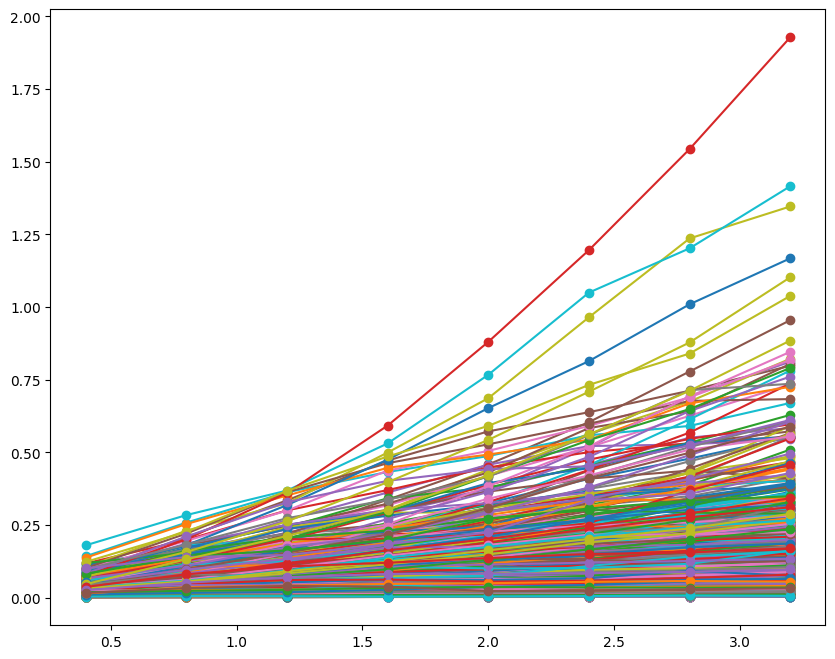

In [18]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- helpers (same as you had) ---
def msd_function(t, D, alpha):
    return 4 * D * (t ** alpha)

def calculate_alpha(msd_values, time_intervals):
    initial_guess = [1.0, 1.0]
    params, _ = curve_fit(msd_function, np.asarray(time_intervals, dtype=float), np.asarray(msd_values, dtype=float), p0=initial_guess)
    return float(params[1])

def calculate_msd(x, y, max_tau):
    N = len(x)
    msd_values = []
    for tau in range(1, max_tau + 1):
        sq = []
        for i in range(N - tau):
            dx = x[i + tau] - x[i]
            dy = y[i + tau] - y[i]
            sq.append(dx*dx + dy*dy)
        msd_values.append(np.mean(sq) if len(sq) else np.nan)
    return msd_values

# --- order tracks & add time column ---
grouped_by_tracks = df.groupby('TRACK_ID')
ordered_tracks = grouped_by_tracks.apply(lambda x: x.sort_values(by='FRAME'))
ordered_tracks.reset_index(drop=True, inplace=True)

# imaging interval (s) — adjust if needed
delta_t = 0.4
ordered_tracks['Time (s)'] = delta_t * (1 + ordered_tracks.groupby('TRACK_ID').cumcount())
grouped_by_tracks = ordered_tracks.groupby('TRACK_ID')

# --- compute MSD per track (no .append) ---
max_tau = 8
msd_records = []   # will hold rows for msd_df
plot_t = np.arange(1, max_tau + 1) * delta_t

plt.figure(figsize=(10, 8))
for track_id, group in grouped_by_tracks:
    x = group['POSITION_X'].to_numpy()
    y = group['POSITION_Y'].to_numpy()
    msd_values = calculate_msd(x, y, max_tau)
    time_intervals = np.arange(1, max_tau + 1, dtype=float) * delta_t

    # add record for this track
    msd_records.append({
        'TRACK_ID': track_id,
        'MSD': np.asarray(msd_values, dtype=float),
        'time_intervals': time_intervals,
    })

    # plot
    plt.plot(plot_t, msd_values, marker='o')

msd_df = pd.DataFrame(msd_records)

# --- fit alpha per track ---
msd_df['alpha'] = msd_df.apply(lambda r: calculate_alpha(r['MSD'], r['time_intervals']), axis=1)

# classify diffusion type (unchanged thresholds)
normal_df  = msd_df[(msd_df['alpha'] > 0.8) & (msd_df['alpha'] < 1.2)].copy()
super_df   = msd_df[(msd_df['alpha'] >= 1.2)].copy()
confined_df= msd_df[(msd_df['alpha'] <= 0.8)].copy()

normal_df['type of diffusion']   = 'normal'
super_df['type of diffusion']    = 'super'
confined_df['type of diffusion'] = 'confined'

combined_msd_df = pd.concat([normal_df, super_df, confined_df], ignore_index=True)

# --- compute D per τ with alpha on τ, then summarize D per track (median is robust) ---
def per_tau_D(row):
    msd_vals = np.asarray(row['MSD'], dtype=float)
    taus = np.asarray(row['time_intervals'], dtype=float)
    a = float(row['alpha'])
    return msd_vals / (4.0 * (taus ** a))

msd_df['D_per_tau'] = msd_df.apply(per_tau_D, axis=1)
msd_df['D_median'] = msd_df['D_per_tau'].apply(lambda arr: np.nanmedian(arr))

# this replaces your prior 'grouped_diffusion' that used α=1
grouped_diffusion = (
    msd_df[['TRACK_ID', 'D_median']]
    .rename(columns={'D_median': 'Diffusion_Coefficient'})
)




### Fit for alpha to define the type of diffusion (normal, confined, directed motion)

In [20]:
# --- NEW: compute per-τ diffusion coefficients with alpha on tau ---
import numpy as np

# D(τ) = MSD(τ) / [4 * (τΔt)^α]
msd_df['D_per_tau'] = msd_df.apply(
    lambda r: np.asarray(r['MSD']) / (4.0 * (np.asarray(r['time_intervals']) ** float(r['alpha']))),
    axis=1
)

# Choose a single D per track (median across τ is robust; adjust if you prefer first-lag, linear window, etc.)
msd_df['D_median'] = msd_df['D_per_tau'].apply(lambda arr: np.nanmedian(arr))

# Build grouped_diffusion from this consistent definition
grouped_diffusion = (
    msd_df[['TRACK_ID', 'D_median']]
    .rename(columns={'D_median': 'Diffusion_Coefficient'})
    .drop_duplicates(subset=['TRACK_ID'])
)


normal_df = msd_df[(msd_df['alpha'] > 0.8) & (msd_df['alpha'] < 1.2)]
super_df = msd_df[(msd_df['alpha'] >= 1.2)]
confined_df = msd_df[(msd_df['alpha'] <= 0.8)]

normal_df['type of diffusion'] = 'normal'
super_df['type of diffusion'] = 'super'
confined_df['type of diffusion'] = 'confined'

# Concatenate the three DataFrames into a single DataFrame
combined_msd_df = pd.concat([normal_df, super_df, confined_df], ignore_index=True)
combined_msd_diffusion_df = pd.merge(combined_msd_df, grouped_diffusion, on='TRACK_ID')

#Conveet diffusion coefficient to nm/s
combined_msd_diffusion_df['Diffusion_Coefficient'] = combined_msd_diffusion_df['Diffusion_Coefficient']

#combined_msd_diffusion_df.to_csv(data_dir+'diffusion_analysis.csv', index=None)
coordinates_df = pd.merge(combined_msd_diffusion_df, df, on='TRACK_ID')

### Attribute tracks to single cells

In [22]:
# Get information from dapi image
label_mask = label(mask)
        
#assign a specific array to single cells
max_number_of_cells = np.amax(label_mask) 

cells_array = np.arange(1, max_number_of_cells + 1) 

# Reflect the image vertically
reflected_image = np.flipud(label_mask)

# Define a dictionary mapping diffusion types to colors
diffusion_colors = {'normal': 'blue', 'super': 'green', 'confined': 'red'}

# Determine the conversion factor
conversion_factor = 15.4083  # pixels to micrometers

# Determine the extent of the image
height, width = reflected_image.shape
extent_image = [0, width / conversion_factor, 0, height / conversion_factor]  # extent in micrometers

# Create a figure and plot the reflected image
plt.figure(figsize=(15.5, 10))
plt.imshow(reflected_image, cmap='gray', origin='upper', extent=extent_image)

# Plot all tracks
for track_id, track_data in coordinates_df.groupby('TRACK_ID'):
    # Sort track data by the frame column
    track_data_sorted = track_data.sort_values(by='FRAME')
    
    # Get the diffusion type for the track
    diffusion_type = track_data_sorted['type of diffusion'].iloc[0]
    
    # Get the color corresponding to the diffusion type
    color = diffusion_colors.get(diffusion_type, 'black')
    
    # Plot the track with the determined color, connecting dots in the order of the frame column
    plt.plot(track_data_sorted['POSITION_X'], track_data_sorted['POSITION_Y'], color=color, linewidth=0.8)

# Add legend for diffusion types
legend_elements = [mlines.Line2D([0], [0], color=color, lw=1, label=diffusion_type) for diffusion_type, color in diffusion_colors.items()]
plt.legend(handles=legend_elements, loc='upper right')

# Set labels and title
plt.xlabel('X-coordinate (µm)', fontsize=16)
plt.ylabel('Y-coordinate (µm)', fontsize=16)

plt.gca().invert_yaxis()  # Invert Y-axis
#plt.savefig(data_dir + 'tracks_overlay.pdf', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'mask' is not defined

In [7]:
# Determine the conversion factor
conversion_factor = 15.4083  # pixels to micrometers

# Reflect the image vertically and scale it
reflected_image = np.flipud(mask)
reflected_image_height, reflected_image_width = reflected_image.shape
reflected_extent_image = [0, reflected_image_width / conversion_factor, 0, reflected_image_height / conversion_factor]  # extent in micrometers

# Create an empty list to store measurements
measurements = []

# Iterate through each cell in the labeled mask
for cell in cells_array:
    # Get the properties of the region corresponding to the current cell
    region_props = regionprops(label_mask)
    
    # Find the region with label equal to the current cell
    for region in region_props:
        if region.label == cell:
            # Extract bounding box coordinates and scale them
            minr_scaled, minc_scaled, maxr_scaled, maxc_scaled = [coord / conversion_factor for coord in region.bbox]
            
            # Now, we iterate through each track to check if it overlaps with the current cell
            for track_id, track_data in coordinates_df.groupby('TRACK_ID'):
                # Check if any point of the track lies within the bounding box of the current cell
                if any((minc_scaled <= track_data['POSITION_X']) & (track_data['POSITION_X'] <= maxc_scaled) &
                       (minr_scaled <= track_data['POSITION_Y']) & (track_data['POSITION_Y'] <= maxr_scaled)):
                    # If there is overlap, store the measurements for the current cell and track
                    # along with the diffusion information
                    measurements.append({
                        'cell_id': cell,
                        'track_id': track_id,
                        'type_of_diffusion': track_data['type of diffusion'].iloc[0],
                        'diffusion_coefficient': track_data['Diffusion_Coefficient'].iloc[0]
                        # Add more properties as needed
                    })
            break 
# Convert the measurements list to a DataFrame
measurements_df = pd.DataFrame(measurements)
# Convert the measurements list to a DataFrame
measurements_df.to_csv(data_dir + 'track_analysis_single_cell.csv', index=None)

### Filter masks by area

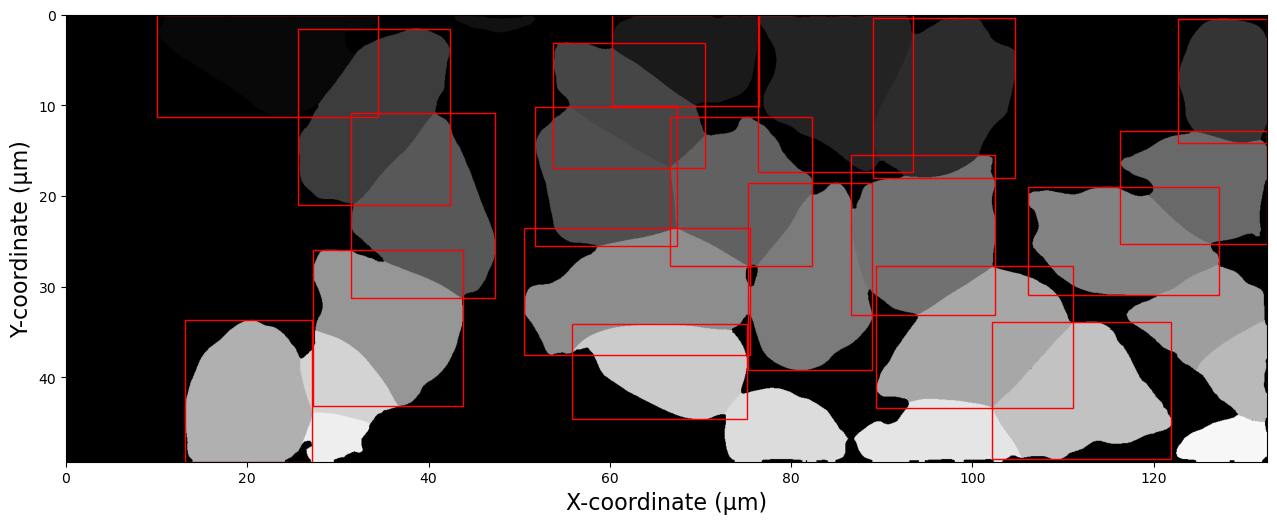

In [8]:

label_mask = label(mask)

# Assign a specific array to single cells
max_number_of_cells = np.amax(label_mask)
cells_array = np.arange(1, max_number_of_cells + 1)

# Reflect the image vertically
reflected_image = np.flipud(label_mask)

# Define a dictionary mapping diffusion types to colors
diffusion_colors = {'normal': 'blue', 'super': 'green', 'confined': 'red'}

# Determine the conversion factor
conversion_factor = 15.4083  # pixels to micrometers

# Determine the extent of the image
height, width = reflected_image.shape
extent_image = [0, width / conversion_factor, 0, height / conversion_factor]  # extent in micrometers

# Create a figure and plot the reflected image
plt.figure(figsize=(15.5, 10))
plt.imshow(reflected_image, cmap='gray', origin='upper', extent=extent_image)

# Create an empty list to store valid cell labels
valid_cell_labels = []

# Iterate through each cell in the labeled mask
for cell in cells_array:
    # Get the properties of the region corresponding to the current cell
    region_props = regionprops(label_mask)
    
    # Find the region with label equal to the current cell
    for region in region_props:
        if region.label == cell:
            # Measure the area of the current cell and convert it to micrometers squared
            cell_area = region.area * (conversion_factor ** 2)
            
            # Set a threshold for the cell area (e.g., 100 square micrometers)
            area_threshold = 6000000
            
            # Check if the area is larger than the threshold
            if cell_area >= area_threshold:
                valid_cell_labels.append(cell)
                break  # Move to the next cell

# Plot only the cells with valid areas
for region in region_props:
    if region.label in valid_cell_labels:
        # Get the bounding box coordinates of the current cell and convert them to micrometers
        minr_scaled, minc_scaled, maxr_scaled, maxc_scaled = [coord / conversion_factor for coord in region.bbox]
        
        # Plot a rectangle representing the cell on the image
        rect = plt.Rectangle((minc_scaled, minr_scaled), maxc_scaled - minc_scaled, maxr_scaled - minr_scaled,
                             fill=False, edgecolor='red', linewidth=1)
        plt.gca().add_patch(rect)

# Set labels and title
plt.xlabel('X-coordinate (µm)', fontsize=16)
plt.ylabel('Y-coordinate (µm)', fontsize=16)
plt.gca().invert_yaxis()  # Invert Y-axis
plt.show()

In [9]:
# Determine the conversion factor
conversion_factor = 15.4083  # pixels to micrometers

# Reflect the image vertically and scale it
reflected_image = np.flipud(mask)
reflected_image_height, reflected_image_width = reflected_image.shape
reflected_extent_image = [0, reflected_image_width / conversion_factor, 0, reflected_image_height / conversion_factor]  # extent in micrometers

# Create an empty list to store measurements
measurements = []              
                
                
# Iterate through each cell in the labeled mask
for cell in cells_array:
    # Get the properties of the region corresponding to the current cell
    region_props = regionprops(label_mask)
    
    # Find the region with label equal to the current cell
    for region in region_props:
        if region.label == cell:
            # Measure the area of the current cell and convert it to micrometers squared
            cell_area = region.area * (conversion_factor ** 2)
            #print(cell_area)
            # Check if the area is larger than a certain threshold (e.g., 10 square micrometers)
            if cell_area >= 6000000:
                # Extract bounding box coordinates and scale them
                minr_scaled, minc_scaled, maxr_scaled, maxc_scaled = [coord / conversion_factor for coord in region.bbox]
                
                # Now, we iterate through each track to check if it overlaps with the current cell
                for track_id, track_data in coordinates_df.groupby('TRACK_ID'):
                    # Check if any point of the track lies within the bounding box of the current cell
                    if any((minc_scaled <= track_data['POSITION_X']) & (track_data['POSITION_X'] <= maxc_scaled) &
                           (minr_scaled <= track_data['POSITION_Y']) & (track_data['POSITION_Y'] <= maxr_scaled)):
                        # If there is overlap, store the measurements for the current cell and track
                        # along with the diffusion information
                        measurements.append({
                            'cell_id': cell,
                            'track_id': track_id,
                            'type_of_diffusion': track_data['type of diffusion'].iloc[0],
                            'diffusion_coefficient': track_data['Diffusion_Coefficient'].iloc[0]
                            # Add more properties as needed
                        })
            break
    # Convert the measurements list to a DataFrame
measurements_df = pd.DataFrame(measurements)
# Convert the measurements list to a DataFrame
measurements_df.to_csv(data_dir + 'track_analysis_single_cell_filtered_by_area.csv', index=None)

In [5]:
data_dir = "//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/DMSO_rep2/DMSO_control_15/tracking_strong_filters/"

In [6]:
file_path1 = data_dir + 'track_analysis_single_cell_filtered_by_area.csv'
file_path2 = data_dir + 'track_analysis_single_cell.csv'

# Load CSV files
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Divide "Diffusion_Coefficient" column by 1000
df1['diffusion_coefficient'] /= 1000
df2['diffusion_coefficient'] /= 1000

# Save the modified DataFrames by overwriting the original files
df1.to_csv(file_path1, index=False)
df2.to_csv(file_path2, index=False)

FileNotFoundError: [Errno 2] No such file or directory: '//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/DMSO_rep2/DMSO_control_15/tracking_strong_filters/track_analysis_single_cell_filtered_by_area.csv'

### Combine replicates

In [3]:
base_dir_rep1 = r'//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/DMSO_rep1/'

# List of positions
positions_rep1 = ['DMSO_control_4', 'DMSO_control_5', 'DMSO_control_6', 'DMSO_control_7', 'DMSO_control_8', 'DMSO_control_9', 'DMSO_control_10', 'DMSO_control_11']

# Initialize an empty list to store DataFrames
dfs_rep1 = []

# Iterate over positions
for pos in positions_rep1:
    # Construct the full path to the CSV file
    csv_path = os.path.join(base_dir_rep1, pos, 'tracking_strong_filters', 'track_analysis_single_cell_filtered_by_area.csv')
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Create a new column combining 'cell_id' with 'pos'
    df['cell_id_pos'] = df['cell_id'].astype(str) + '_' + pos
    
    # Append the DataFrame to the list
    dfs_rep1.append(df)

# Concatenate all DataFrames in the list along the rows
concatenated_df_rep1 = pd.concat(dfs_rep1, ignore_index=True)


In [4]:
base_dir_rep2 = r'//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/CHX_CG1_057/DMSO_rep2/'

# List of positions
positions_rep2 = ['DMSO_control_1', 'DMSO_control_2', 'DMSO_control_3', 'DMSO_control_4', 'DMSO_control_12', 'DMSO_control_13', 'DMSO_control_14']

# Initialize an empty list to store DataFrames
dfs_rep2 = []

# Iterate over positions
for pos in positions_rep2:
    # Construct the full path to the CSV file
    csv_path = os.path.join(base_dir_rep2, pos, 'tracking_strong_filters', 'track_analysis_single_cell_filtered_by_area.csv')
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Create a new column combining 'cell_id' with 'pos'
    df['cell_id_pos'] = df['cell_id'].astype(str) + '_' + pos
    
    # Append the DataFrame to the list
    dfs_rep2.append(df)

# Concatenate all DataFrames in the list along the rows
concatenated_df_rep2 = pd.concat(dfs_rep2, ignore_index=True)
concatenated_df_rep2

,cell_id,track_id,type_of_diffusion,diffusion_coefficient,cell_id_pos
0,2,108,confined,0.034430,2_DMSO_control_1
1,2,124,confined,0.001006,2_DMSO_control_1
2,2,131,confined,0.000485,2_DMSO_control_1
3,2,132,confined,0.007126,2_DMSO_control_1
4,2,136,confined,0.017064,2_DMSO_control_1
...,...,...,...,...,...
11138,44,20988,confined,0.018095,44_DMSO_control_14
11139,44,21314,confined,0.005267,44_DMSO_control_14
11140,44,21446,confined,0.002491,44_DMSO_control_14
11141,44,23502,normal,0.021651,44_DMSO_control_14


In [5]:
##Check how many cells are left
grouped_data = concatenated_df_rep2.groupby(['cell_id_pos'])['diffusion_coefficient'].mean().reset_index()
len(grouped_data)

112

In [6]:
color_palette = sns.color_palette("YlGnBu")

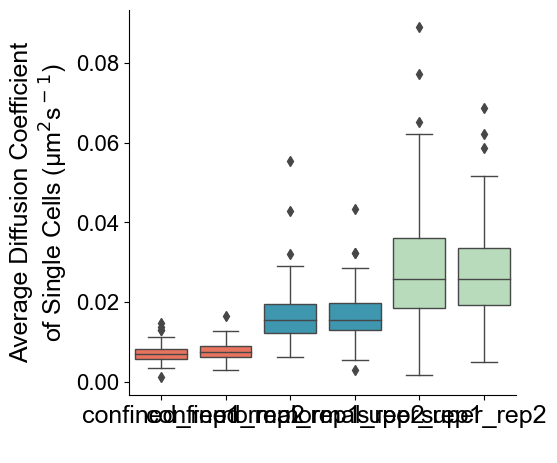

In [7]:
# Add a column indicating the type of diffusion with _rep1 or _rep2 suffix
concatenated_df_rep1['type_of_diffusion_rep'] = concatenated_df_rep1['type_of_diffusion'] + '_rep1'
concatenated_df_rep2['type_of_diffusion_rep'] = concatenated_df_rep2['type_of_diffusion'] + '_rep2'

# Concatenate the dataframes
concatenated_df = pd.concat([concatenated_df_rep1, concatenated_df_rep2], ignore_index=True)

# Calculate the percentage for each category for each cell_id

grouped_data = concatenated_df.groupby(['cell_id_pos', 'type_of_diffusion_rep'])['diffusion_coefficient'].mean().reset_index()

# Boxplot using seaborn
plt.figure(figsize=(5, 5))

colors = {'normal': color_palette[3], 'super': color_palette[1], 'confined': 'tomato',
         'normal_rep1': color_palette[3], 'super_rep1': color_palette[1], 'confined_rep1': 'tomato',
         'normal_rep2': color_palette[3], 'super_rep2': color_palette[1], 'confined_rep2': 'tomato'}

order = ['confined_rep1', 'confined_rep2','normal_rep1','normal_rep2', 'super_rep1', 'super_rep2']

plt.style.use('style.mplstyle.txt')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
    
sns.boxplot(x='type_of_diffusion_rep', y='diffusion_coefficient', data=grouped_data, order=order, palette=colors, linewidth=1)
#plt.title('Replicate 1', fontsize=15)
plt.xlabel(' ')
plt.ylabel('Average Diffusion Coefficient\nof Single Cells (µm$^2$s$^-$$^1$)', fontsize=18
          )
plt.xticks(rotation=0, ha='center', fontsize=18)
plt.yticks(fontsize=16)
sns.despine()

#plt.savefig(save_dir + 'boxplot_replicates_combined_thesis.pdf', dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig(save_dir + 'boxplot_replicates_combined.eps', dpi=300, bbox_inches='tight', transparent=True)


plt.show()

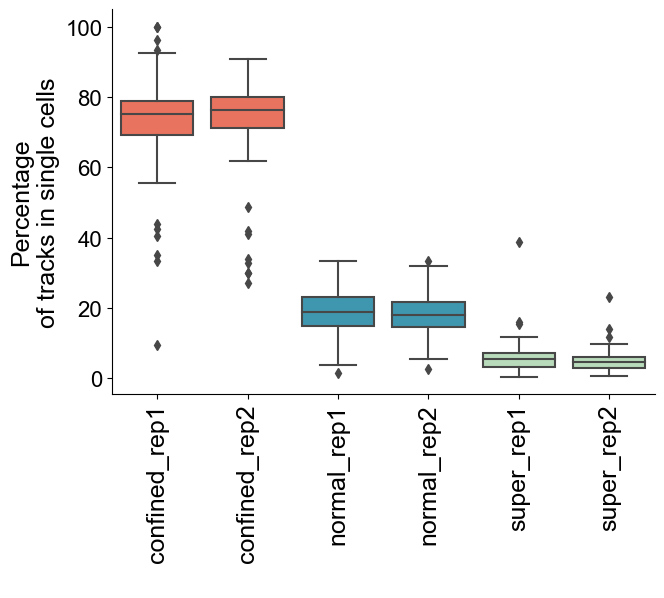

In [9]:
# Calculate the percentage for each category for each cell_id
grouped_data = concatenated_df.groupby(['cell_id_pos', 'type_of_diffusion_rep']).size()  # Get the count for each category for each cell_id
percentage_data = grouped_data.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))  # Calculate the percentage for each category for each cell_id

# Reset index to make cell_id and type_of_diffusion as columns
percentage_data = percentage_data.reset_index(name='percentage')
# Calculate the percentage for each category for each cell_id

# Boxplot using seaborn
plt.figure(figsize=(7, 5))

colors = {'normal': color_palette[3], 'super': color_palette[1], 'confined': 'tomato',
         'normal_rep1': color_palette[3], 'super_rep1': color_palette[1], 'confined_rep1': 'tomato',
         'normal_rep2': color_palette[3], 'super_rep2': color_palette[1], 'confined_rep2': 'tomato'}


order = ['confined_rep1', 'confined_rep2','normal_rep1','normal_rep2', 'super_rep1', 'super_rep2']

sns.boxplot(x='type_of_diffusion_rep', y='percentage', data=percentage_data, order=order, palette=colors)
#plt.title('Replicate 1', fontsize=15)
plt.xlabel(' ')
plt.ylabel('Percentage\nof tracks in single cells', fontsize=18)
plt.xticks(rotation=90, ha='center', fontsize=18)
plt.yticks(fontsize=16)
sns.despine()

plt.savefig(save_dir + 'boxplot_%_replicates_combined_thesis.pdf', dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig(save_dir + 'boxplot_%_replicates_combined.eps', dpi=300, bbox_inches='tight', transparent=True)


plt.show()

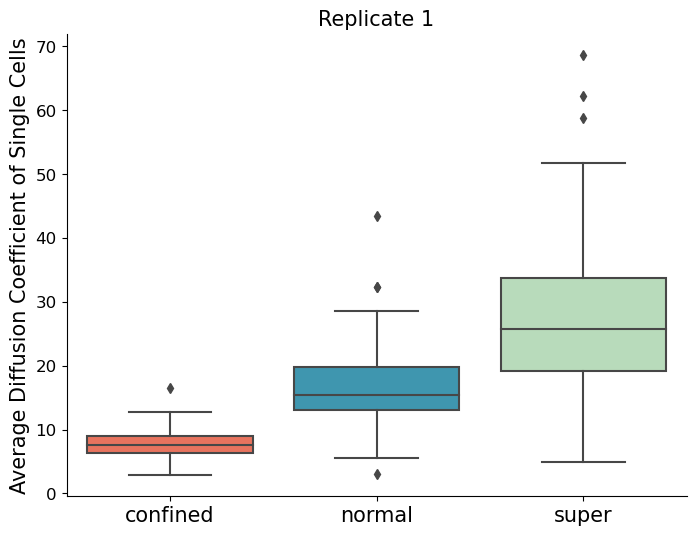

In [21]:
# Calculate the percentage for each category for each cell_id

grouped_data = concatenated_df_rep2.groupby(['cell_id_pos', 'type_of_diffusion'])['diffusion_coefficient'].mean().reset_index()

# Boxplot using seaborn
plt.figure(figsize=(8, 6))

colors = {'normal': color_palette[3], 'super': color_palette[1], 'confined': 'tomato'}


order = ['confined', 'normal', 'super']

sns.boxplot(x='type_of_diffusion', y='diffusion_coefficient', data=grouped_data, order=order, palette=colors)
plt.title('Replicate 1', fontsize=15)
plt.xlabel(' ')
plt.ylabel('Average Diffusion Coefficient of Single Cells', fontsize=15)
plt.xticks(rotation=0, ha='center', fontsize=15)
plt.yticks(fontsize=12)
sns.despine()

plt.savefig(save_dir + 'boxplot_rep2.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(save_dir + 'boxplot_rep2.eps', dpi=300, bbox_inches='tight', transparent=True)


plt.show()

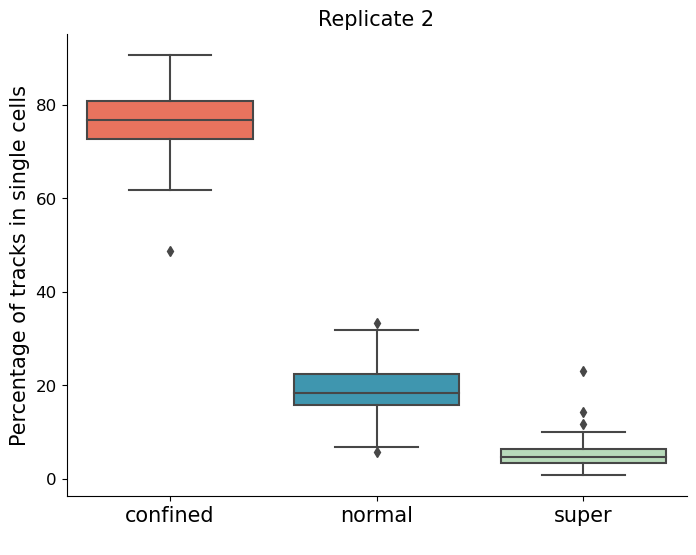

In [11]:
# Calculate the percentage for each category for each cell_id
grouped_data = concatenated_df_rep2.groupby(['cell_id_pos', 'type_of_diffusion']).size()  # Get the count for each category for each cell_id
percentage_data = grouped_data.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))  # Calculate the percentage for each category for each cell_id

# Reset index to make cell_id and type_of_diffusion as columns
percentage_data = percentage_data.reset_index(name='percentage')

# Boxplot using seaborn
plt.figure(figsize=(8, 6))



order = ['confined', 'normal', 'super']

sns.boxplot(x='type_of_diffusion', y='percentage', data=percentage_data, order=order, palette=colors)
plt.title('Replicate 2', fontsize=15)
plt.xlabel(' ')
plt.ylabel('Percentage of tracks in single cells', fontsize=15)
plt.xticks(rotation=0, ha='center', fontsize=15)
plt.yticks(fontsize=12)
sns.despine()
plt.savefig(save_dir + 'boxplot_percentage_rep2.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(save_dir + 'boxplot_percentage_rep2.eps', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

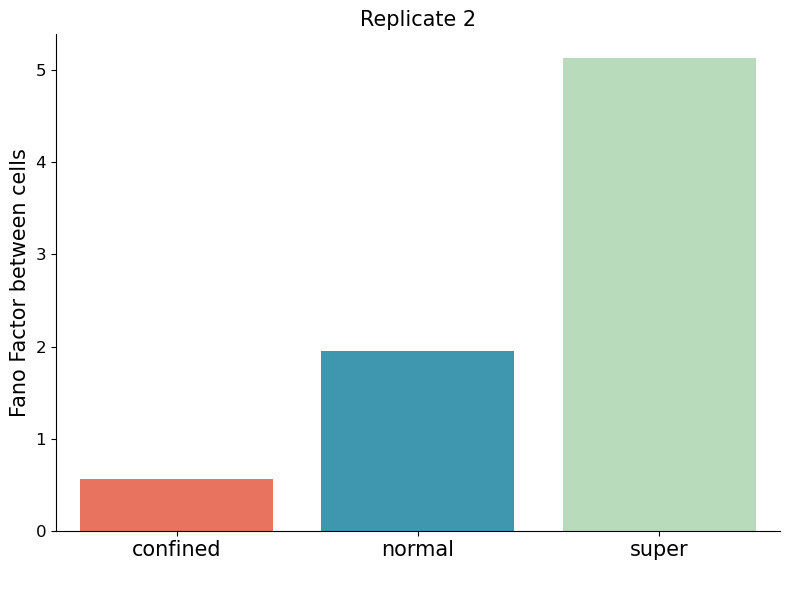

In [14]:
# Calculate the mean diffusion coefficient for each type of diffusion between cell
grouped_between_cells = concatenated_df_rep2.groupby(['cell_id_pos', 'type_of_diffusion'])['diffusion_coefficient'].mean().reset_index()

# Calculate the overall mean and variance across all cells for each type of diffusion
overall_mean_by_diffusion = grouped_between_cells.groupby('type_of_diffusion')['diffusion_coefficient'].mean()
overall_var_by_diffusion = grouped_between_cells.groupby('type_of_diffusion')['diffusion_coefficient'].var()

# Calculate the Fano factor
fano_factor = overall_var_by_diffusion / overall_mean_by_diffusion
# Create a DataFrame from the calculated Fano factor
fano_factor_df = pd.DataFrame({'Fano Factor': fano_factor})

# Reset index to make 'type_of_diffusion' a column
fano_factor_df.reset_index(inplace=True)

#colors = {'normal': 'cornflowerblue', 'super': 'mediumseagreen', 'confined': 'tomato'}

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='type_of_diffusion', y='Fano Factor', data=fano_factor_df, palette=colors)
plt.title('Replicate 2', fontsize=15)
plt.xlabel(' ')
plt.ylabel('Fano Factor between cells', fontsize=15)
plt.xticks(rotation=0, ha='center', fontsize=15)
plt.yticks(fontsize=12)
##plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
sns.despine()
plt.savefig(save_dir + 'fano_between_cell_rep2.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(save_dir + 'fano_between_cell_rep2.eps', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

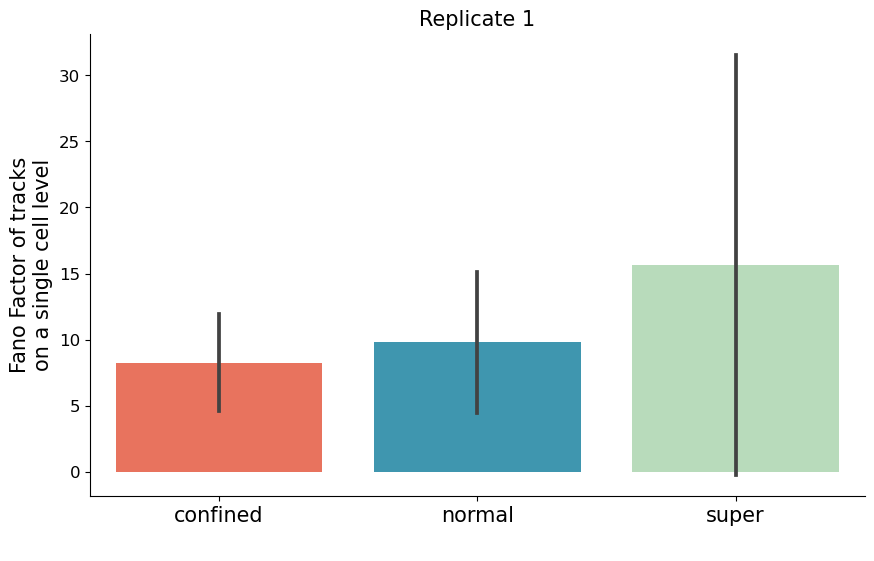

In [19]:
grouped_within_cells = concatenated_df_rep1.groupby(['cell_id_pos', 'type_of_diffusion'])['diffusion_coefficient'].agg(['mean', 'var'])

# Calculate the Fano factor within cells
grouped_within_cells['fano_factor'] = grouped_within_cells['var'] / grouped_within_cells['mean']
grouped_within_cells=grouped_within_cells.reset_index()

# Boxplot using seaborn
plt.figure(figsize=(10, 6))
colors = {'normal': color_palette[3], 'super': color_palette[1], 'confined': 'tomato'}
order = ['confined', 'normal', 'super']
# Plot bar plots with standard deviation bars
sns.barplot(x='type_of_diffusion', y='fano_factor', data=grouped_within_cells, ci='sd', palette=colors, order=order)

# Set plot title and labels
plt.title('Replicate 1', fontsize=15)
plt.xlabel(' ', fontsize=15)
plt.ylabel('Fano Factor of tracks\non a single cell level', fontsize=15)
plt.xticks(rotation=0, ha='center', fontsize=15)
plt.yticks(fontsize=12)
sns.despine()
plt.savefig(save_dir + 'fano_between_tracks_of_same_cell_rep1.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(save_dir + 'fano_between_tracks_of_same_cell_rep1.eps', dpi=300, bbox_inches='tight', transparent=True)
plt.show()